<a href="https://colab.research.google.com/github/samoliver3/capstone-STRIP-AI/blob/main/STRIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mayo Clinic STRIP AI: Predicting Stroke Etiology from Whole Slide Digital Pathology Images
This notebook represents exploratory analysis and modeling for predicting ischemic stroke etiology.
* Student name: Sam Oliver
* Student pace: self-paced
* Scheduled project review: 
* Instructor name: Abhineet Kulkarni

# Overview of This Project
Stroke Thromboembolism Registery of Imaging and Pathology (STRIP) is a project run by the Mayo Clinic Neurovascular Lab across multiple centers with the following goal: histopathologic characterization of thromboemboli of various etiologies and examining clot composition and its relation to mechanical thrombectomy revascularization. This project will take advantage of resources collected by STRIP to predict stroke etiology (the origin of the stroke).
## Description of the problem
In the United States, over 700,000 people suffer an ischemic stroke every year, and stroke is the second most common cause of death in the world. Around 25% of people that have a stroke suffer one or more additional strokes. Identifying stroke etiology improves the likelihood of survival. 
## The dataset
The data from this project will come from the Mayo Clinic and is also part of a Kaggle competition. This dataset comprises more than one-thousand digital pathology images representing a blood clot that has manifested from a patient that has suffered an acute ischemic stroke (AIS).
## The stakeholder
The stakeholder is the Mayo Clinic, which is offering cash rewards to the creators of the top five best-scoring entries according to a scoring algorithm. The Mayo Clinic is asking for entries to classify images into one of the two major AIS categories for each image in a test set. These two major categories include Cardioembolic (CE) strokes and Large Artery Atherosclerosis (LAA) strokes.
## The evaluation algorithm
The evaluation algorithm is a weighted multi-class logarithmic loss that produces an effect of placing equal importance on each category for the final score.

# Exploratory Data Analysis (EDA)
## Import packages and data

In [ ]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import os
from os import listdir
from google.colab import drive
from pathlib import Path

from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras import activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

import datetime

from tensorflow.random import set_seed
set_seed(13)

In [ ]:
# define paths for the data
train_path = '/content/drive/MyDrive/Flatiron/Capstone/train_images'
test_path = '/content/drive/MyDrive/Flatiron/Capstone/test'

In [ ]:
# load csv files in
train_df = pd.read_csv('/content/drive/MyDrive/Flatiron/Capstone/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Flatiron/Capstone/test.csv')

train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


There are several different centers that have contributed images to this dataset. I'm not sure what the image_num column is supposed to keep track of.

In [ ]:
test_df.head()

,image_id,center_id,patient_id,image_num
0,006388_0,11,006388,0
1,008e5c_0,11,008e5c,0
2,00c058_0,11,00c058,0
3,01adc5_0,11,01adc5,0


The test dataset does not have a label column because of the nature of the Kaggle competition. It is concealed so that predictions are made on the test set and scored with the evaluation algorithm on the Kaggle competition.

## Preview metadata

First, look for null-data and inspect type of data

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    4 non-null      object
 1   center_id   4 non-null      int64 
 2   patient_id  4 non-null      object
 3   image_num   4 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 256.0+ bytes


No null data in either set.
Now, look into distribution of images in respect to the target in the train dataset.

In [ ]:
train_df.label.value_counts()

CE     547
LAA    207
Name: label, dtype: int64

In the train dataset, there are 547 Cardiacembolic images and 207 Large Artery Atherosclerosis images.
Let's visualize this distribution below.

Text(0.5, 1.0, 'Distribution of Stroke Etiology in the Train Dataset')

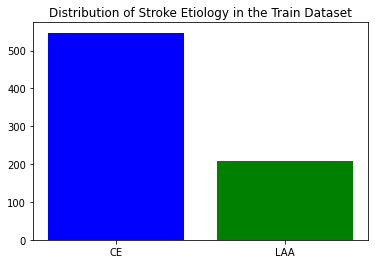

In [ ]:
# visualize distribution
plt.bar(['CE', 'LAA'], [547, 207], color=['b', 'g'])
plt.title('Distribution of Stroke Etiology in the Train Dataset')

The distribution is almost 2:1 in favor of CE.